In [1]:
import sqlite3

import numpy as np
import pandas as pd
import networkx as nx

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

“个人关系组成之集合体的概念化，提供历史学家评估古人于何时、如何，及为何利用亲族与非亲族关系。 社会网络关系分析家发现，人们须从不同的社会关系中、不同的人身上，寻求情绪上与经济上的支持。 因此，仅研究人们如何于危机时刻利用亲族关系已不足够；相反地，历史学的研究必须涵盖过去人们如何为不同目的而利用亲族与朋友关系，以及此一利用关系的优势与限制。 事实上，社会网络关系做为一种研究方法不仅有助于此一论辩，更帮助历史学家 Charles Tilly 所提出的挑战：将平民百姓的日常生活与大规模的社会变迁作有意义的链接。 ” Charles Wetherell 



从苏轼及其亲友的往来书信中归纳出社交网络关系（“朋友圈”），然后借助 networkx 对其社交网络关系进行可视化和分析

In [2]:
import warnings

warnings.filterwarnings('ignore')

In [3]:
db='data/cbdb_sqlite.db'

In [4]:
# 查找 person_id 函数
def getPersonId(person_name):
    ''' Get person_id
    @param person_name: str
    @return person_id: str
    '''
    sql = '''
    SELECT c_personid
    FROM biog_main
    WHERE c_name_chn = '{0}'
    '''.format(person_name)

    try:
        person_id = str(pd.read_sql(sql, con=sqlite3.connect(db)).iloc[0, 0])
        return person_id
    except:
        print("No such person.")

In [5]:
# 查找苏轼的 person_id，注意要使用繁体中文
person_id = getPersonId('蘇軾')
# 打印 person_id
print(person_id)

3767


In [6]:
sql = '''
SELECT a.c_personid person_id
    , b1.c_name_chn person_a
    , c_assoc_id assoc_id
    , b2.c_name_chn person_b
    , a.c_assoc_code assoc_code
    , c.c_assoc_desc_chn assoc_desc
FROM assoc_data a
LEFT JOIN biog_main b1 
    ON a.c_personid = b1.c_personid
LEFT JOIN biog_main b2 
    ON a.c_assoc_id = b2.c_personid
LEFT JOIN assoc_codes c 
    ON a.c_assoc_code = c.c_assoc_code
WHERE (a.c_personid = {0}
    OR a.c_personid IN (
        SELECT c_personid 
        FROM assoc_data 
        WHERE c_assoc_id = {0}
        AND c_assoc_code IN ('429', '430', '431', '432', '433', '434', '435', '436'))
    OR a.c_assoc_id IN (
        SELECT c_assoc_id
        FROM assoc_data 
        WHERE c_personid = {0}
        AND c_assoc_code IN ('429', '430', '431', '432', '433', '434', '435', '436'))) 
    AND a.c_assoc_code IN ('429', '430', '431', '432', '433', '434', '435', '436')
'''.format(person_id)

person_assoc = pd.read_sql(sql, con=sqlite3.connect(db))

In [7]:
# 查看 DataFrame 信息
person_assoc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2595 entries, 0 to 2594
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   person_id   2595 non-null   int64 
 1   person_a    2595 non-null   object
 2   assoc_id    2595 non-null   int64 
 3   person_b    2595 non-null   object
 4   assoc_code  2595 non-null   int64 
 5   assoc_desc  2595 non-null   object
dtypes: int64(3), object(3)
memory usage: 121.8+ KB


In [18]:
person_assoc.head()

person_id person_a  assoc_id person_b  assoc_code assoc_desc
0         13      晁補之      1301      呂仲甫         429        致書Y
1         13      晁補之      1724       杜純         429        致書Y
2         13      晁補之      1960       吳充         429        致書Y
3         13      晁補之      3767       蘇軾         429        致書Y
4         13      晁補之      3767       蘇軾         429        致書Y

In [8]:
person_assoc[(person_assoc['person_id'] == int(person_id)) | (person_assoc['assoc_id'] == int(person_id))].count()

person_id     550
person_a      550
assoc_id      550
person_b      550
assoc_code    550
assoc_desc    550
dtype: int64

In [9]:
# 打印所有关系的名称
for i in person_assoc['assoc_desc'].unique():
    print(i)

致書Y
被致書由Y
答Y書
收到Y的答書
致Y啓
收到Y的啓
答Y啓
收到Y的答啓


In [10]:
# 生成图
person_G = nx.from_pandas_edgelist(person_assoc, source='person_a', target='person_b', edge_attr='assoc_desc')

In [11]:
# 打印图信息
print(nx.info(person_G))
print('Density: {0}'.format(nx.density(person_G)))

Name: 
Type: Graph
Number of nodes: 614
Number of edges: 906
Average degree:   2.9511
Density: 0.004814257855051517


In [12]:
person_betweenness = pd.Series(nx.betweenness_centrality(person_G), name='Betweenness')
person_person = pd.Series.to_frame(person_betweenness)
person_person['Closeness'] = pd.Series(nx.closeness_centrality(person_G))
person_person['PageRank'] = pd.Series(nx.pagerank_scipy(person_G))
person_person['Degree'] = pd.Series(dict(nx.degree(person_G)))
desc_betweenness = person_person.sort_values('Betweenness', ascending=False)
desc_betweenness.head(10)

Betweenness  Closeness  PageRank  Degree
蘇軾      0.591204   0.603941  0.111023     211
歐陽修     0.317891   0.533507  0.070228     141
黃庭堅     0.257789   0.475562  0.063531     109
王安石     0.146049   0.457122  0.038774      79
畢仲游     0.086661   0.434444  0.022120      42
司馬光     0.078387   0.456441  0.020660      41
韓琦      0.054205   0.430175  0.016937      37
張耒      0.026246   0.418716  0.008772      18
米芾      0.023558   0.385535  0.007968      15
張方平     0.022055   0.452399  0.007934      18

In [13]:
#pos = nx.circular_layout(person_G)
pos = nx.kamada_kawai_layout(person_G)
#pos = nx.shell_layout(person_G)
#pos = nx.spring_layout(person_G)
#pos = nx.random_layout(person_G)

In [14]:
# 绘制函数
def draw_graph(df, top):
    ''' Draw Graph
    @param df: DataFrame
    @param top: int, numbers of top
    '''    
    nodes = df.index.values.tolist() #生成节点列表
    edges = nx.to_edgelist(person_G) #生成边列表
    # 生成无向度量图
    metric_G = nx.Graph()
    metric_G.add_nodes_from(nodes)
    metric_G.add_edges_from(edges)
    # 生成 Top n 的标签列表
    top_labels = {}
    for node in nodes[:top]:
        top_labels[node] = node
    # 生成节点尺寸列表
    node_sizes = []
    for node in nodes:
            node_sizes.append(df.loc[node]['Degree'] * 16 ** 2)
    # 设置图形尺寸
    plt.figure(1, figsize=(64, 64))
    # 绘制图形
    nx.draw(metric_G, pos=pos, node_color='#cf1322', with_labels=False)
    nx.draw_networkx_nodes(metric_G, pos=pos, nodelist=nodes[:top], node_color='#a8071a', node_size=node_sizes[:top])
    nx.draw_networkx_nodes(metric_G, pos=pos, nodelist=nodes[top:], node_color='#a3b1bf', node_size=node_sizes[top:])
    nx.draw_networkx_edges(metric_G, pos=pos, edgelist=edges, edge_color='#d9d9d9', arrows=False)
    nx.draw_networkx_labels(metric_G, pos=pos, font_size=20, font_color='#555555')
    nx.draw_networkx_labels(metric_G, pos=pos, labels=top_labels, font_size=28, font_color='#1890ff')
    # 保存图片
    plt.savefig('tmp.png')

In [15]:
from matplotlib.font_manager import _rebuild

_rebuild() #reload一下

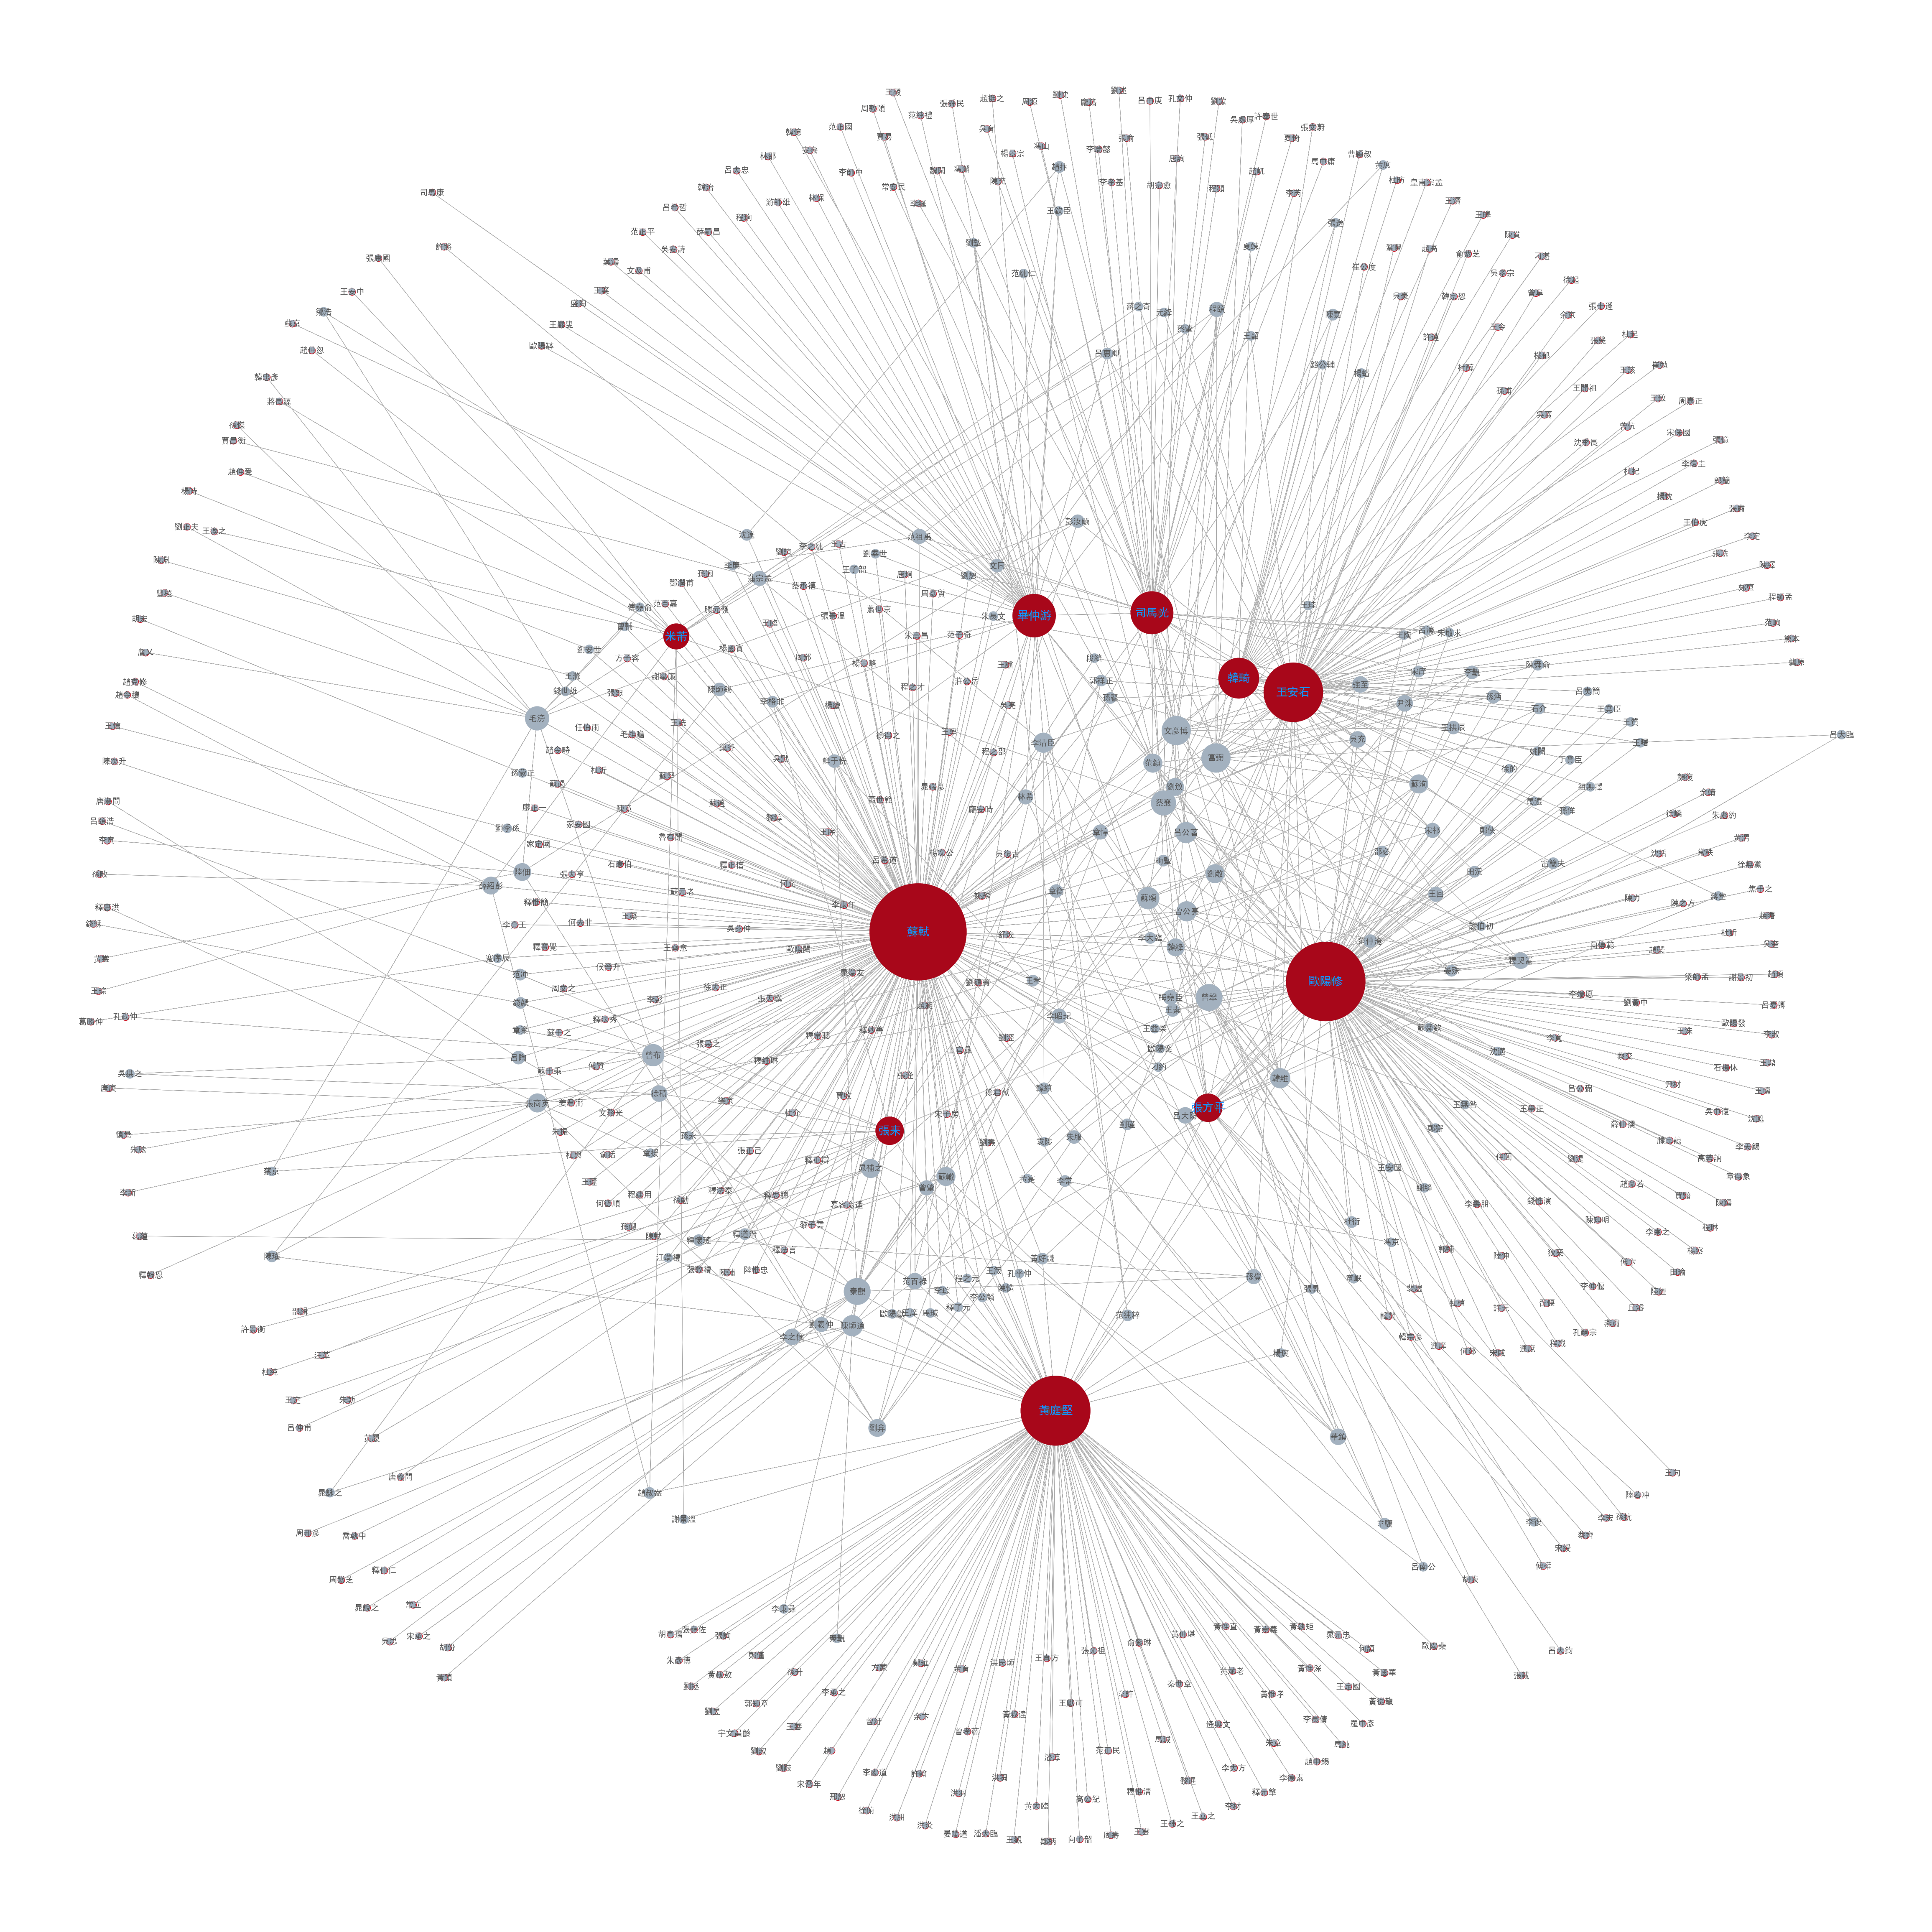

In [16]:
draw_graph(desc_betweenness, 10)